# __Projektarbeit - Winequality__
## *Felix Romer*

![FOTOTAPETEw](fototapeten-roter-und-weiser-wein-splash-von-zwei-glasern.jpg.jpg)

***
## Structure
1. [Import](#import) 
2. [Statistical overview](#statistical-overview)
3. [Correletion between features](#correletion-between-features)
4. [Strongest Correlation of each feature](#strongest-correlation-of-each-feature)
5. [Quantitative correlation between sensory prefernce and individual feature](#quantitative-correlation-between-sensory-prefernce-and-individual-feature)
6. [Prediction of sensory preference](#prediction-of-sensory-preference)

## Import
### Package-Import

In [2]:
#Basics
import numpy as np
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

#Preprocessing
from sklearn.preprocessing import StandardScaler

#Regression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier


#Hilfsskripte
from Preprocessing_aux import *
from plotfunctions import *

%load_ext autoreload
%autoreload 2

### Data Import

In [3]:

#Importing
red_wine= pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

#Combinde both Datasets
red_wine['Wine type'] = 'red wine'
white_wine['Wine type'] = 'white wine'
all_wine = pd.concat([red_wine,white_wine], ignore_index=True)
display(red_wine.head(2),red_wine.shape,
        white_wine.head(2), white_wine.shape,
        all_wine.tail(2), all_wine.shape)

#Column headings including units
units_list = ['Fixed acidity (g/dm3)','Volatile acidity (g/dm3)','Citric acid (g/dm3)','Residual sugar (g/dm3)',
'Chlorides (g/dm3)','Free sulfur dioxide (mg/dm3)', 'Total sulfur dioxide (mg/dm3)', 'Density (g/cm3)','pH',
 'Sulphates (g/dm3)','Alcohol (vol.%)', 'Sensory preferences']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine type
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red wine
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red wine


(1599, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,white wine
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,white wine


(4898, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine type
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white wine
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white wine


(6497, 13)

# Statistical overview

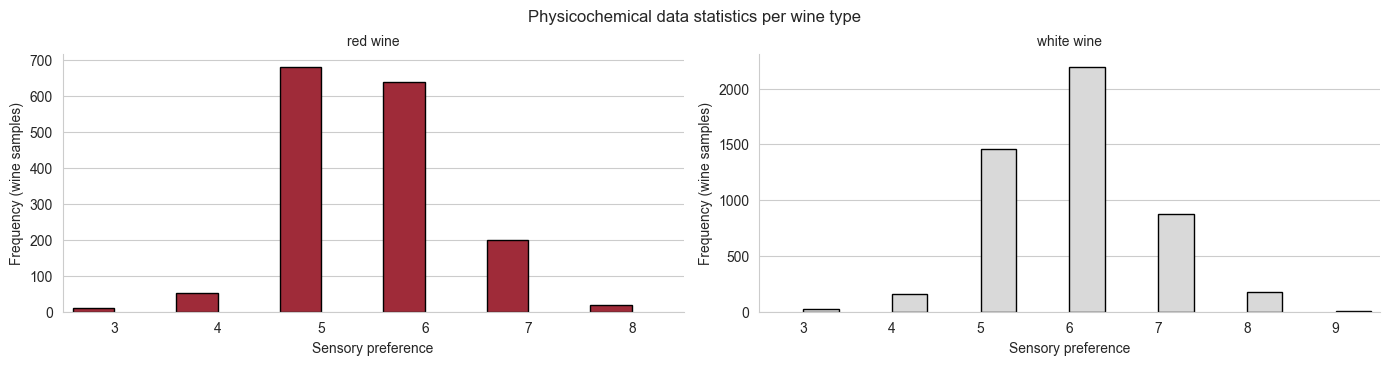

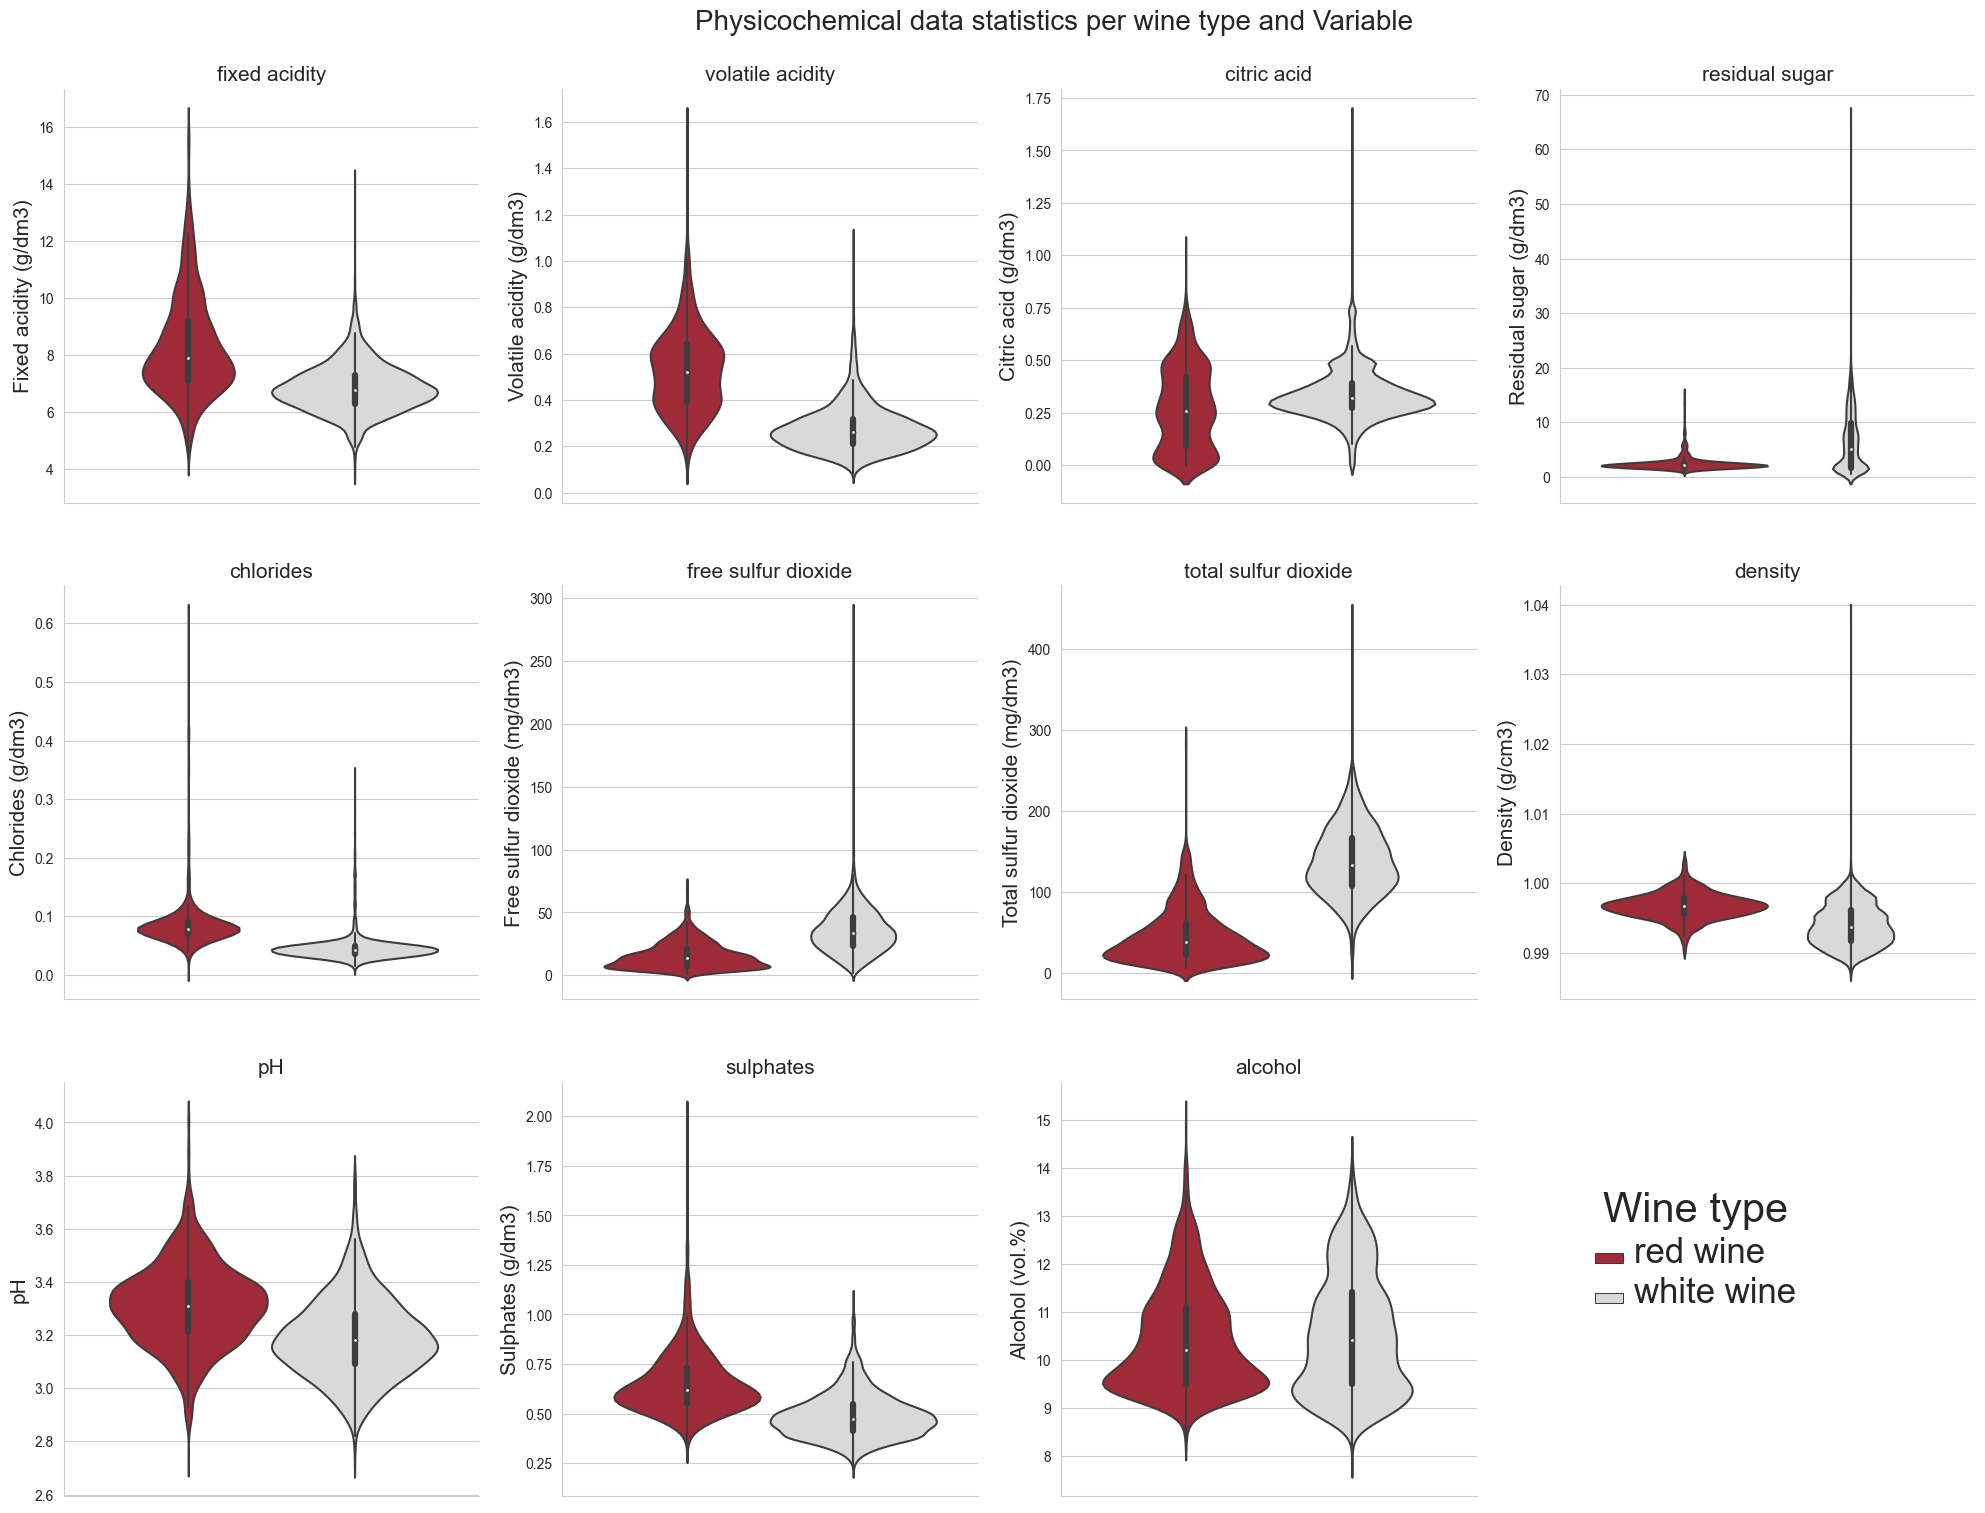

In [5]:
#Visulatisation Set up
color_wine= ['#b2182b','#d9d9d9']
sns.set_style('whitegrid')

#Plot of the sensory preferences
s=sns.catplot(data=all_wine, x='quality', kind='count', hue='Wine type',col='Wine type',
            col_wrap=2, sharey=False, sharex= False, height=3.5, aspect=2,
            palette=color_wine, edgecolor = 'black')

    #Customization
s.fig.suptitle('Physicochemical data statistics per wine type', y=1.03)
s.set_titles('{col_name}')
s.set(xlabel='Sensory preference', ylabel='Frequency (wine samples)')

#Plot of the physicochemical data
phys_df=all_wine.melt(id_vars=['Wine type', 'quality'])
phys_df['name']=phys_df.variable
p=sns.catplot(data=phys_df, x='variable', y='value', kind='violin', hue="Wine type", col="name",
                 col_wrap=4, sharey=False, sharex=False, palette=color_wine)

    #Customization
    #Function to use on later plots with similar  layout
def phys_df_labeles(plot, title,tick='',xlab=None):
    #Title 
    plot.fig.suptitle(title, y=1.03, size = 20)
    plot.set_titles('{col_name}', size = 15)
    
    #Legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(.75, .25))
    plt.setp(plot._legend.get_title(), fontsize=30)
    plt.setp(plot._legend.get_texts(), fontsize=25)

    #Subplot orientation
    plt.subplots_adjust(hspace=0.2, wspace=0.2)

    #Axis Labels
    plot.set(xlabel=xlab)
    plot.set_xticklabels(tick)
    labels=units_list[0:11]
    for i in np.arange(11):
        plot.axes[i].set_ylabel(labels[i], fontsize=15)
phys_df_labeles(p,'Physicochemical data statistics per wine type and Variable')

# Correletion between features
## Correlation overview 

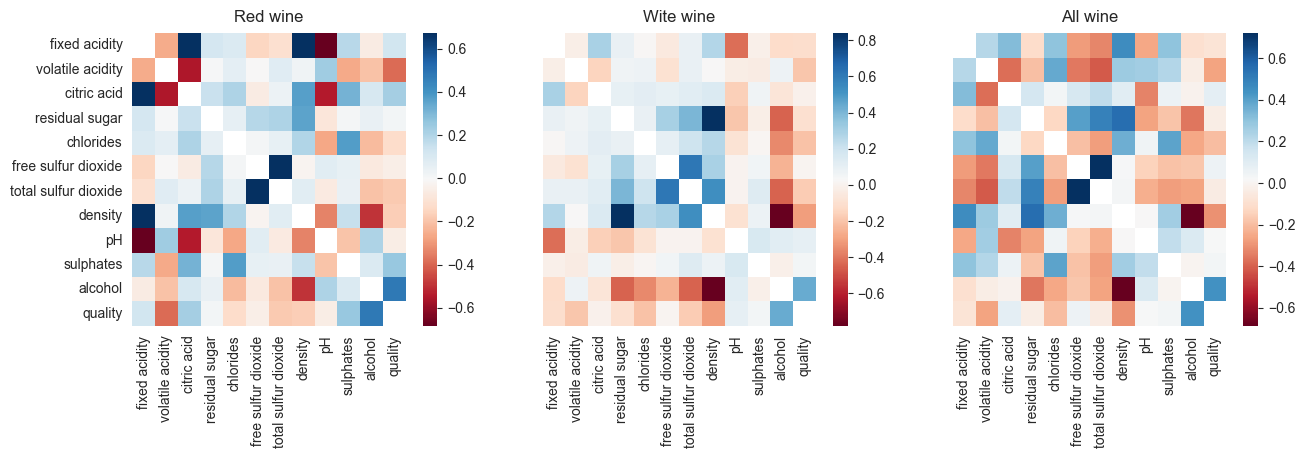

In [6]:
#Filter out correlations equal to 1 (for self corrleations)
filtered_red=red_wine.corr()[red_wine.corr() != 1]
filtered_white=white_wine.corr()[white_wine.corr() != 1]
filtered_all = all_wine.corr()[all_wine.corr() != 1]

#Set up colour palette
c=sns.color_palette('RdBu', as_cmap=True)

#Plot
fig,(ax,ax1, ax2)=plt.subplots(ncols=3, sharey = True, figsize=(15,3.8))
sns.heatmap(filtered_red, cmap=c, ax=ax)
ax.set_title('Red wine', y=1.01)
sns.heatmap(filtered_white, cmap=c, ax=ax1)
ax1.set_title('Wite wine', y=1.01)
sns.heatmap(filtered_all, cmap=c, ax=ax2)
ax2.set_title('All wine', y=1.01)
plt.show()

## Strongest Correlation of each feature

In [7]:
#Funktion to analysie Red wine, White wine and All wine separately
def high_corr(x):
    highest_corr = []
    for label, row in x.iterrows():
        features = []
        features.append(label)
        
        #find local max/min
        index_max_min = np.argmax(abs(row))
        index_max_min = x.columns[index_max_min]
        features.append(index_max_min)

        actual_rowmaxmin = row[index_max_min]
        features.append(actual_rowmaxmin)

        #Move new list in 'highest_corr'
        highest_corr.append(features)
    highest_corr = pd.DataFrame(highest_corr)
    highest_corr.columns = ["Feature_1", "Feature_2", "Pearson_Correlation"]
    highest_corr['Pearson_Correlation_abs']=abs(highest_corr['Pearson_Correlation'])
    highest_corr['1']=1
    return highest_corr.sort_values("Pearson_Correlation_abs", ascending = False)
red_corr = high_corr(filtered_red)
white_corr = high_corr(filtered_white)
all_corr =high_corr(filtered_all)

### Visualization

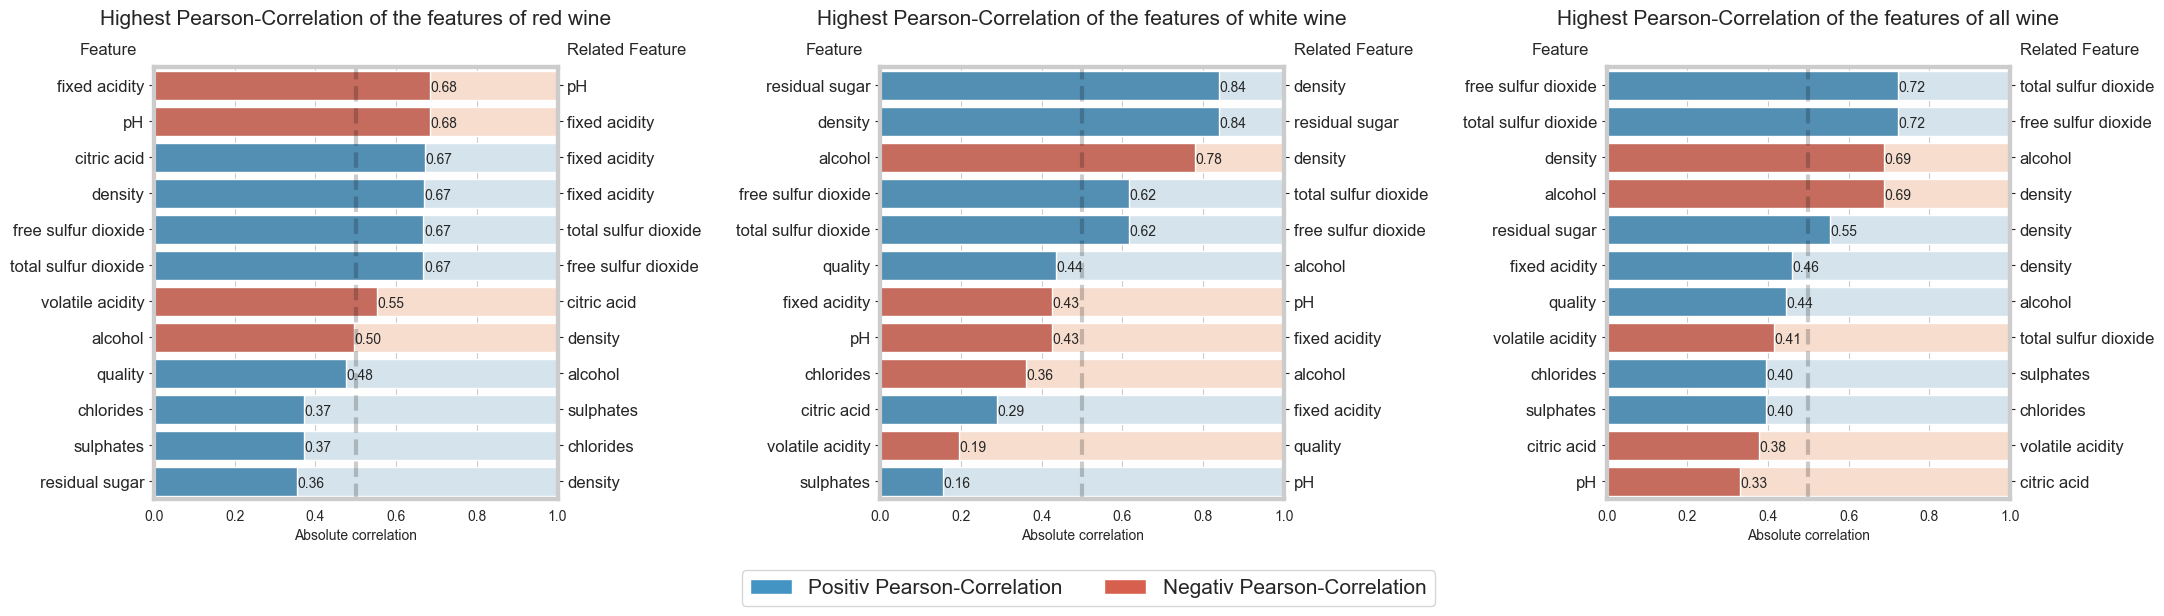

In [73]:
#Colour set up
range = [-1,0,1]
colours= ['#d6604d', '#4393c3']
colours_2=['#fddbc7','#d1e5f0']

#Set up for Subplot
sns.set_style('whitegrid')
fig, (ax, axb, axc) = plt.subplots(ncols=3)

# bar chart 1 -> top bars

for a, df, tit in zip([ax, axb, axc], [red_corr, white_corr, all_corr], ['red wine', 'white wine', 'all wine']):
    #Colorlist
    hue_colours=pd.cut(df['Pearson_Correlation'], bins=range, labels=colours).values
    hue_colours_2=pd.cut(df['Pearson_Correlation'], bins=range, labels=colours_2).values

    #Creat Twin x-axis
    a1=a.twinx()

    #Plot data
    p=sns.barplot(y="Feature_1", x="Pearson_Correlation_abs", data=df, palette=hue_colours, ax=a1)
    a1.set_yticklabels(df['Feature_2'].values, fontsize=12)
    a1.set_ylabel('')
    show_values(p, "h", space=0.001)
    
    #Title
    plt.title('Highest Pearson-Correlation of the features of {}'.format(tit), y=1.08, fontsize=15)
    plt.title('Feature', loc='left', x=-0.185, y=1.01)
    plt.title('Related Feature', loc='right', x=1.32, y=1.01)

    #Second Plot to shwo the corelacted feature
    sns.barplot(y="Feature_1",  x="1", data=df, palette=hue_colours_2 , ax=a)
    a.set_ylabel('')
    a.set_yticklabels(df['Feature_1'].values, fontsize=12)
    plt.xlim(0, 1)
    a.set(xlabel='Absolute correlation')
 
    #Create dottet line at Correlatio = 0.5
    a1.axvline(x = 0.5, linestyle = "--", alpha = .2, color = "black")

#Adjust subplot positioning
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=3,
                    top=1, 
                    wspace=0.8)
                    
# Create customize legend
legend_elements = [Patch(facecolor='#4393c3',label='Positiv Pearson-Correlation'),
                    Patch(facecolor='#d6604d',label='Negativ Pearson-Correlation')]
axb.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, -0.14), ncol=2, fontsize=15)

plt.show()

## Quantitative correlation between sensory prefernce and individual feature
### Person correlation

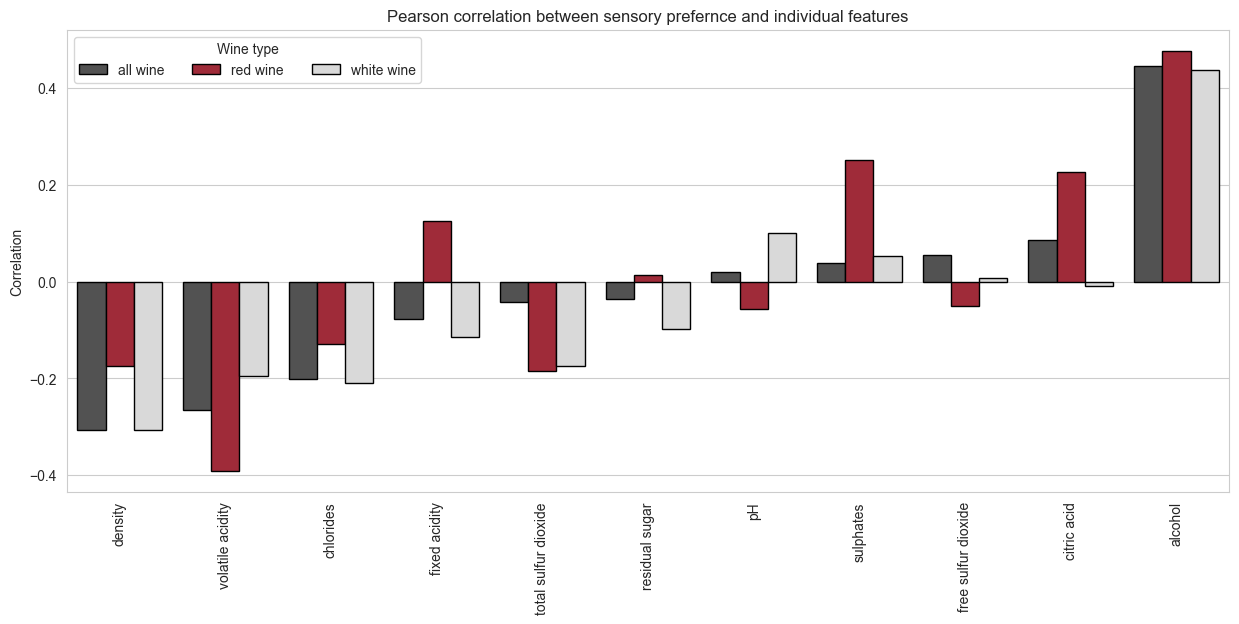

In [11]:
#Get Wine type label to DataFrame; using filtered DataFrames from before
filtered_red['Wine type']='red wine'
filtered_white['Wine type']='white wine'
filtered_all['Wine type']='all wine'

#Concate all 3 DataFrames into one
corr_quality=pd.concat([filtered_red[:-1],filtered_white[:-1], filtered_all[:-1]])

#Filter DataFrame to use only needed columns
corr_quality.reset_index(inplace=True)
corr_quality=corr_quality.iloc[:,[0,12,13]]
corr_quality.sort_values(['Wine type','quality'],inplace=True)

#Set up for Subplot
sns.set_style('whitegrid')
colours_wine= ['#525252','#b2182b','#d9d9d9']

#Plot data
fig,ax=plt.subplots(figsize=(15,6))

g=sns.barplot(x="index", y="quality", data=corr_quality,hue='Wine type', palette=colours_wine, ax=ax,  edgecolor = 'black')
plt.xticks(rotation=90)
plt.legend(title='Wine type', ncol=3)
g.set_title('Pearson correlation between sensory prefernce and individual features')
g.set_ylabel('Correlation')
g.set_xlabel('')
plt.show()

### Spearman correlation

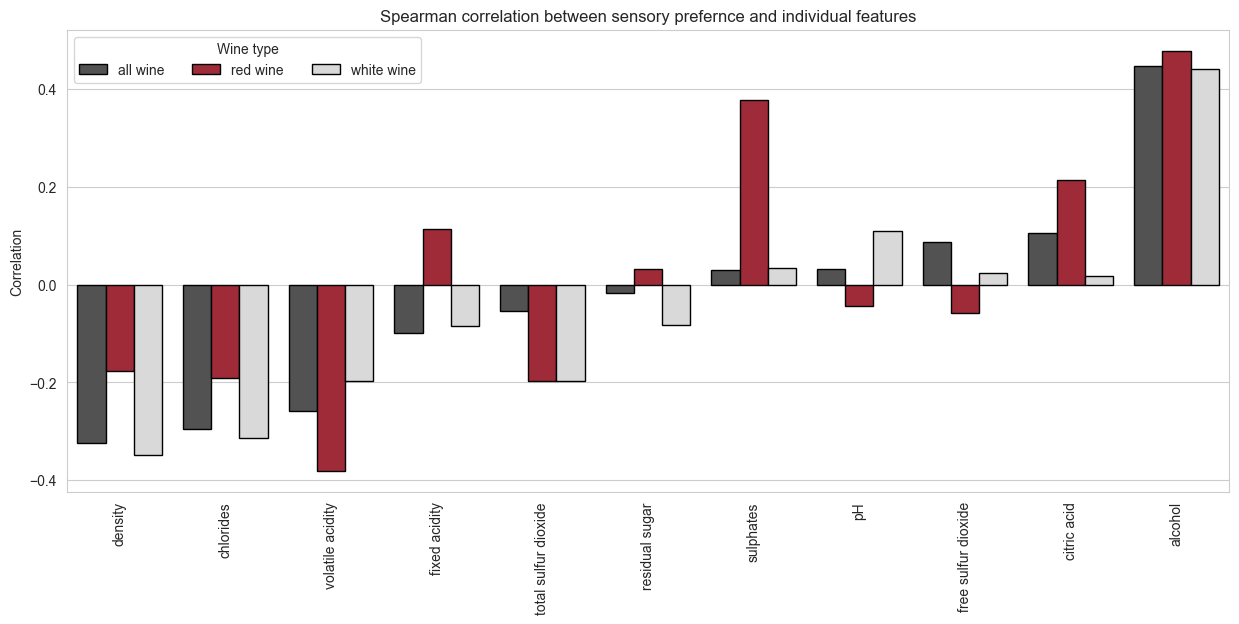

In [10]:
#Spearman
spear_red=red_wine.corr(method='spearman')[red_wine.corr(method='spearman') != 1]
spear_white=white_wine.corr(method='spearman')[white_wine.corr(method='spearman') != 1]
spear_all = all_wine.corr(method='spearman')[all_wine.corr(method='spearman') != 1]
#Get Wine type label to DataFrame; using filtered DataFrames from before
spear_red['Wine type']='red wine'
spear_white['Wine type']='white wine'
spear_all['Wine type']='all wine'

#Concate all 3 DataFrames into one
corr_quality=pd.concat([spear_red[:-1],spear_white[:-1], spear_all[:-1]])

#Filter DataFrame to use only needed columns
corr_quality.reset_index(inplace=True)
corr_quality=corr_quality.iloc[:,[0,12,13]]
corr_quality.sort_values(['Wine type','quality'],inplace=True)

#Set up for Subplot
sns.set_style('whitegrid')
colours_wine= ['#525252','#b2182b','#d9d9d9']

#Plot data
fig,ax=plt.subplots(figsize=(15,6))

g=sns.barplot(x="index", y="quality", data=corr_quality,hue='Wine type', palette=colours_wine, ax=ax,  edgecolor = 'black')
plt.xticks(rotation=90)
plt.legend(title='Wine type', ncol=3)
g.set_title('Spearman correlation between sensory prefernce and individual features')
g.set_ylabel('Correlation')
g.set_xlabel('')
plt.show()

### Qualtiy specifiy relation

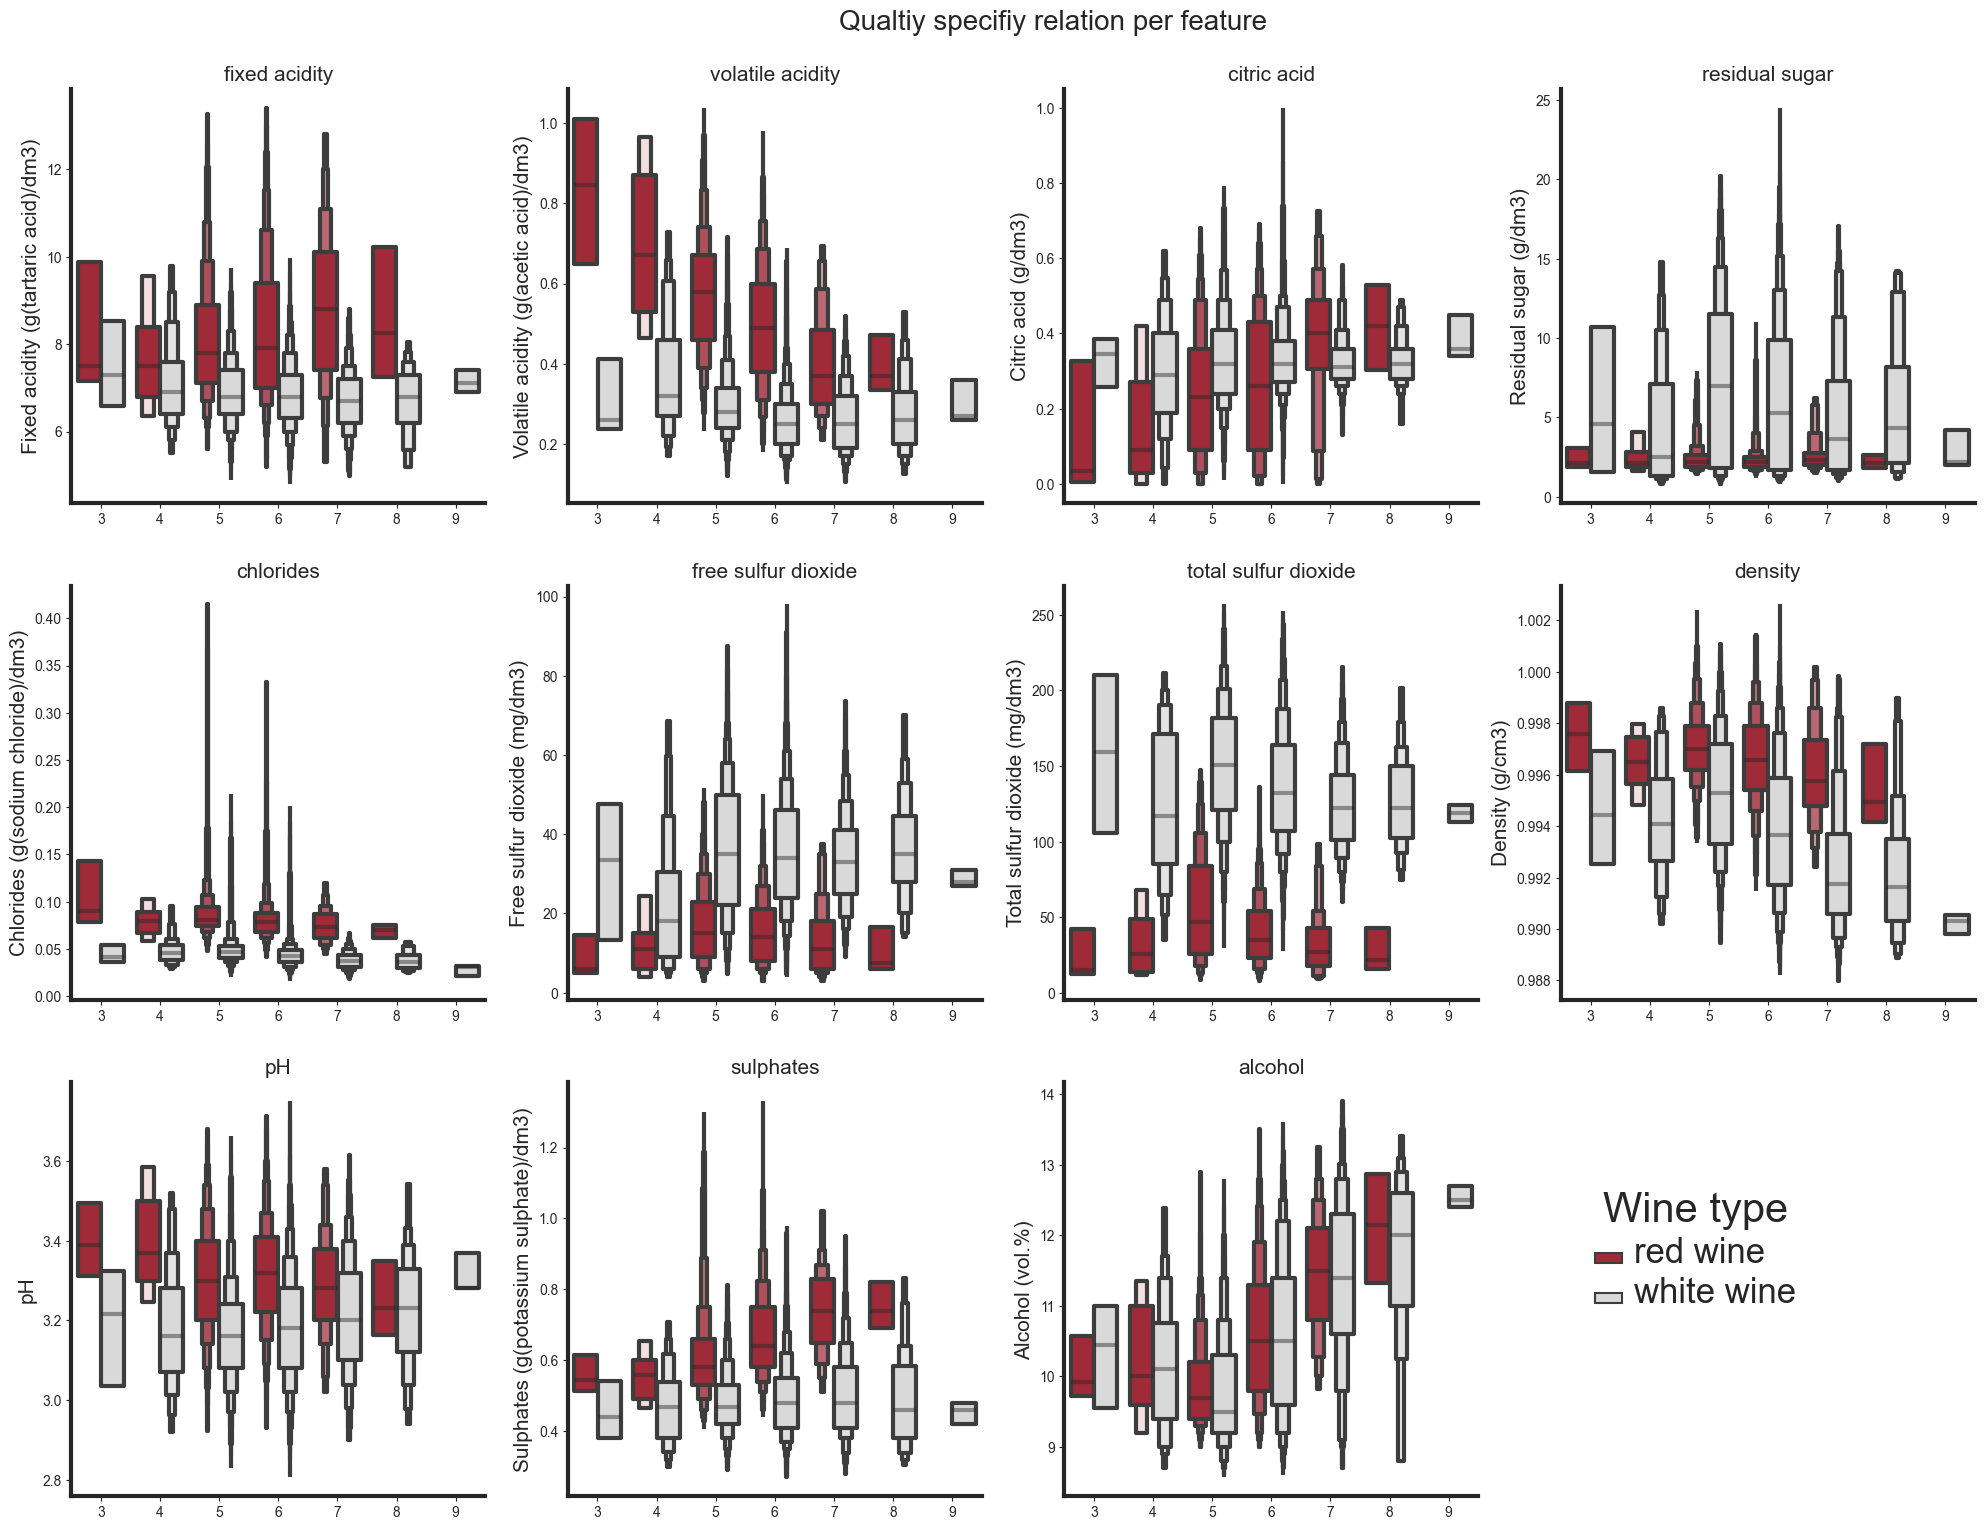

In [17]:
c=sns.catplot(data=phys_df, y='value', x="quality", kind='boxen', col='variable',col_wrap=4, hue="Wine type",palette=color_wine,
 sharey=False, sharex=False, showfliers=False)
phys_df_labeles(c,'Qualtiy specifiy relation per feature',tick=[3,4,5,6,7,8,9])

# Prediction of sensory preference
## With all features

The classification model used for red wine is DecisionTree with a mean cross-val-score of 0.620:


,precision,recall,f1-score,support
3,0.000000,0.000000,0.000000,1.000000
4,0.111111,0.100000,0.105263,10.000000
5,0.628571,0.676923,0.651852,130.000000
6,0.524590,0.484848,0.503937,132.000000
7,0.400000,0.428571,0.413793,42.000000
8,0.000000,0.000000,0.000000,5.000000
accuracy,0.534375,0.534375,0.534375,0.534375
macro avg,0.277379,0.281724,0.279141,320.000000
weighted avg,0.527723,0.534375,0.530289,320.000000


The classification model used for white wine is DecisionTree with a mean cross-val-score of 0.585:


,precision,recall,f1-score,support
3,0.000000,0.000000,0.000000,5.000000
4,0.243243,0.360000,0.290323,25.000000
5,0.591549,0.577320,0.584348,291.000000
6,0.575472,0.564815,0.570093,432.000000
7,0.537234,0.526042,0.531579,192.000000
8,0.309524,0.371429,0.337662,35.000000
accuracy,0.545918,0.545918,0.545918,0.545918
macro avg,0.376170,0.399934,0.385668,980.000000
weighted avg,0.551845,0.545918,0.548434,980.000000


The classification model used for all wine is DecisionTree with a mean cross-val-score of 0.597:


,precision,recall,f1-score,support
3,0.000000,0.000000,0.000000,6.000000
4,0.227273,0.232558,0.229885,43.000000
5,0.569087,0.604478,0.586248,402.000000
6,0.606061,0.569514,0.587219,597.000000
7,0.441558,0.474419,0.457399,215.000000
8,0.290323,0.250000,0.268657,36.000000
9,0.000000,0.000000,0.000000,1.000000
accuracy,0.541538,0.541538,0.541538,0.541538
macro avg,0.304900,0.304424,0.304201,1300.000000
weighted avg,0.542885,0.541538,0.541646,1300.000000


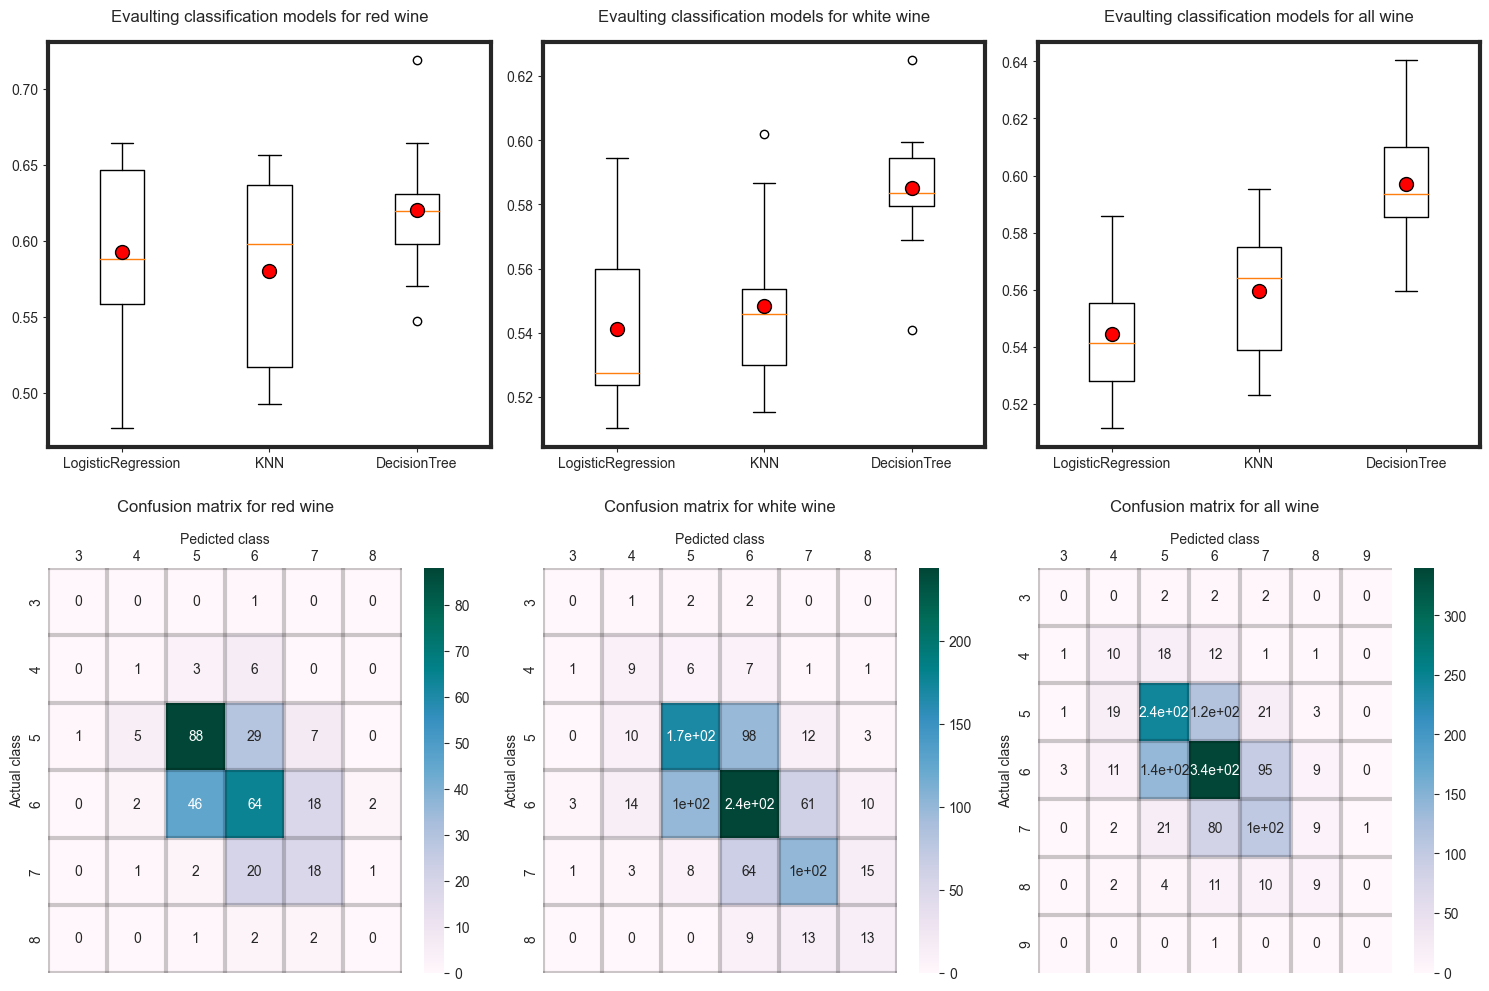

In [70]:
#Funktion to change to input into the Regession model
def reg_func(data=[red_wine, white_wine, all_wine], names=['red wine', 'white wine', 'all wine']):
    fig, ((ax, ax1, ax2),(ax3, ax4, ax5)) =plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    #Set up the linaer regression models
    for df,name, ax_1, ax_2 in zip(data, names, [ax,ax1,ax2], [ax3, ax4, ax5]):
        X=df.drop(['quality', 'Wine type'], axis =1)
        y=df['quality']
        #Split in Test and Train
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
        
        #Scale Data
        X_train_scaled= StandardScaler().fit_transform(X_train)
        X_test_scaled= StandardScaler().fit_transform(X_test)

        #Evaluation of classification models
        models={'LogisticRegression': LogisticRegression(solver='liblinear'), 'KNN':KNeighborsClassifier(), 'DecisionTree': DecisionTreeClassifier()}
        results=[]
        for model in models.values():
            kf=KFold(n_splits=10, shuffle=True,random_state=42)
            cv_result=cross_val_score(model, X_train_scaled, y_train, cv=kf)
            results.append(cv_result)
        
        #Checks with models creats the best results
        if results[0].mean() > results[1].mean():
            if results[0].mean() > results[2].mean():
                reg=LogisticRegression()
                print('The classification model used for {} is LogisticRegression with a mean R-sqrt of {:.3f}:'.format(name, results[0].mean()))
            else:
                reg=DecisionTreeClassifier()
                print('The classification model used for {} is DecisionTree with a mean cross-val-score of {:.3f}:'.format(name, results[2].mean()))
        elif results[1].mean() > results[2].mean():
            reg=KNeighborsClassifier()
            print('The classification model used for {} is KNN with a mean cross-val-score of {:.3f}:'.format(name, results[1].mean()))
        else:
            reg=DecisionTreeClassifier()
            print('The classification model used for {} is DecisionTree with a mean cross-val-score of {:.3f}:'.format(name, results[2].mean()))
        
        #Visualisation of results
        ax_1.boxplot(results, labels=models.keys(), showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
        ax_1.set_title('Evaulting classification models for {}'.format(name), y=1.03)
        
        #Fitting model to train data
        reg.fit(X_train_scaled, y_train)

        #Predicting Target
        y_pred=reg.predict(X_test_scaled)

        #Creating Stat. Report
        report=classification_report(y_test,y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        display(report_df)

        #Cinfusion Matrix
        con_mat=confusion_matrix(y_test, y_pred)
        con_mat_df =pd.DataFrame(con_mat, columns=(str(i) for i in np.arange(3, (len(con_mat)+3))),
                                index=(str(i) for i in np.arange(3, (len(con_mat)+3))))
        
        #Visualtisiton of Confusion Matrix as Heatmap
        PuBuGn=sns.color_palette('PuBuGn', as_cmap=True)
        sns.heatmap(con_mat_df,  cmap=PuBuGn, annot=True, ax=ax_2)
        ax_2.set_xlabel('Pedicted class')
        ax_2.set_ylabel('Actual class')
        ax_2.xaxis.tick_top() 
        ax_2.tick_params(length=0)
        ax_2.xaxis.set_label_position('top')
        ax_2.set_title('Confusion matrix for {}'.format(name), y=1.12)
        for i in np.arange(0,7):
            ax_2.axvline(x = i, linestyle = "-", alpha = .2, color = "black")
            ax_2.axhline(y = i, linestyle = "-", alpha = .2, color = "black")
        
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()  

reg_func()

## With modified features

The classification model used for red wine is DecisionTree with a mean cross-val-score of 0.621:


,precision,recall,f1-score,support
3,0.000000,0.000000,0.000000,1.000000
4,0.090909,0.100000,0.095238,10.000000
5,0.636364,0.700000,0.666667,130.000000
6,0.538462,0.477273,0.506024,132.000000
7,0.377778,0.404762,0.390805,42.000000
8,0.333333,0.200000,0.250000,5.000000
accuracy,0.540625,0.540625,0.540625,0.540625
macro avg,0.329474,0.313672,0.318122,320.000000
weighted avg,0.538271,0.540625,0.537744,320.000000


The classification model used for white wine is DecisionTree with a mean cross-val-score of 0.583:


,precision,recall,f1-score,support
3,0.000000,0.000000,0.000000,5.000000
4,0.142857,0.160000,0.150943,25.000000
5,0.614583,0.608247,0.611399,291.000000
6,0.610979,0.592593,0.601645,432.000000
7,0.520619,0.526042,0.523316,192.000000
8,0.224490,0.314286,0.261905,35.000000
accuracy,0.560204,0.560204,0.560204,0.560204
macro avg,0.352255,0.366861,0.358201,980.000000
weighted avg,0.565483,0.560204,0.562495,980.000000


The classification model used for all wine is DecisionTree with a mean cross-val-score of 0.575:


,precision,recall,f1-score,support
3,0.000000,0.000000,0.000000,6.000000
4,0.126984,0.186047,0.150943,43.000000
5,0.484412,0.502488,0.493284,402.000000
6,0.524254,0.470687,0.496028,597.000000
7,0.381356,0.418605,0.399113,215.000000
8,0.243902,0.277778,0.259740,36.000000
9,0.000000,0.000000,0.000000,1.000000
accuracy,0.454615,0.454615,0.454615,0.454615
macro avg,0.251558,0.265086,0.257016,1300.000000
weighted avg,0.464574,0.454615,0.458523,1300.000000


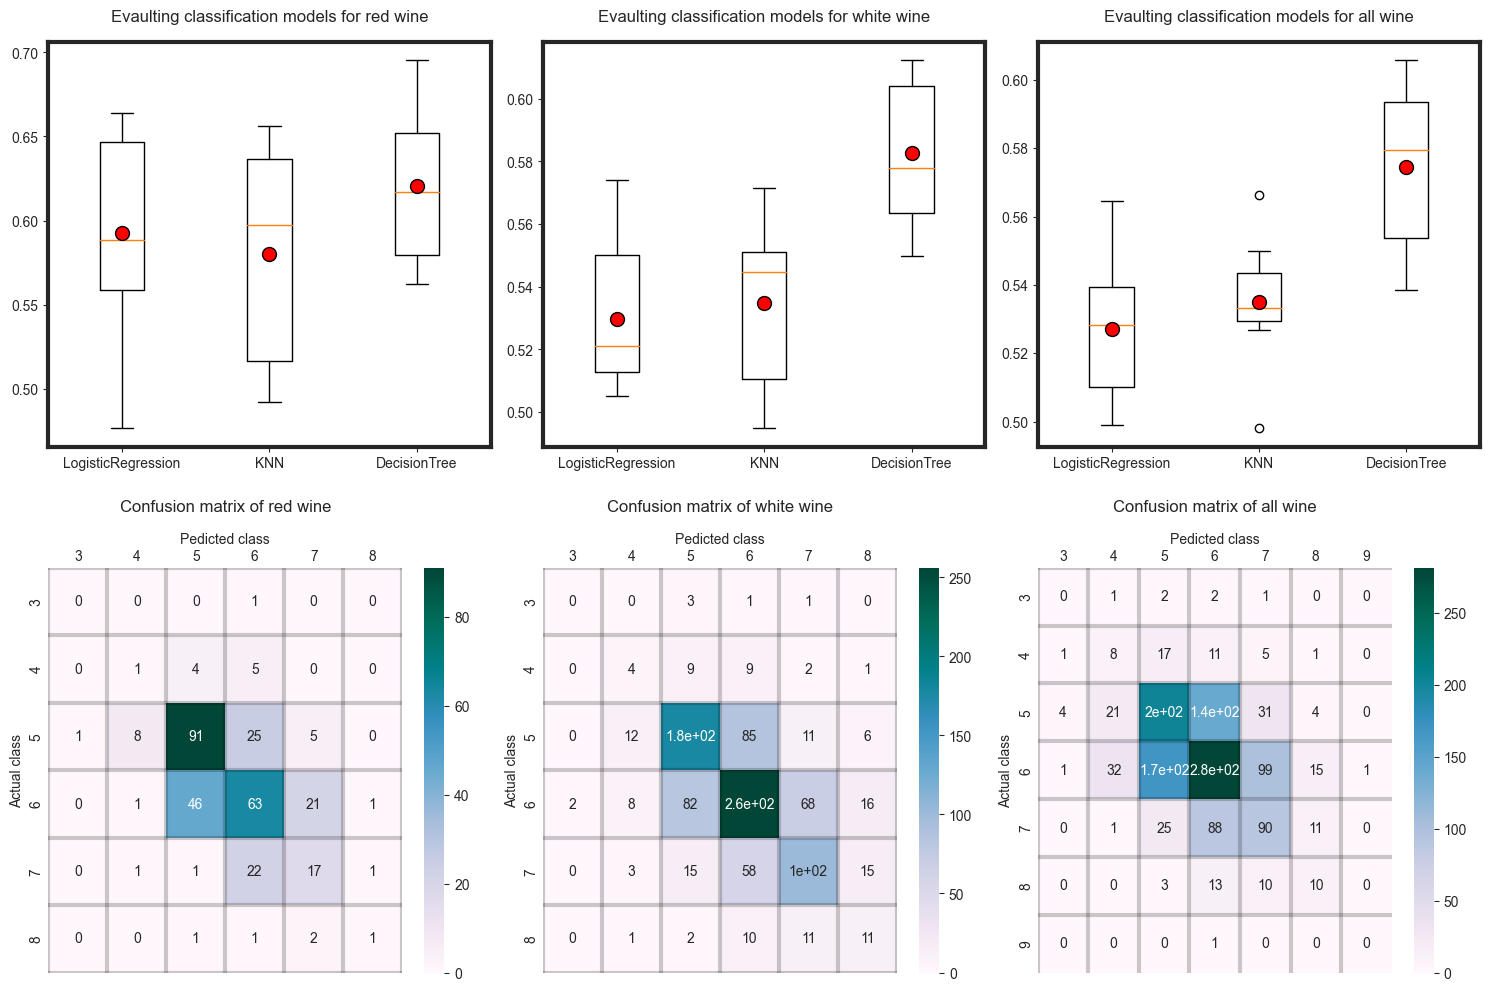

In [44]:
#Relation with alc seems not linear -> new column alc_squr
red_wine['alc_squr']=red_wine['alcohol']**2
white_wine['alc_squr']=white_wine['alcohol']**2
all_wine['alc_squr']=all_wine['alcohol']**2
reg_func(data=[red_wine, white_wine.iloc[:,[0,1,2,4,10,11,12,13]], all_wine.iloc[:,[0,1,2,10,11,12,13]]])

## Discussion
- The strongest correlation with qulatity across both wine types is alcohol content.

- Both Pearson and Spearman Correlation show similar correlations.

- Reduction of the features to those with the highest correlation does not lead to a significant deterioration of the prediction and significantly reduces the computing time.

- Red and white wine partly differ significantly in their biochemical parameters, so that a classification of the wine type should also be possible with this data.